In [2]:
import numpy as np
import pandas as pd

%matplotlib inline 
import matplotlib.pyplot as plt
import os

from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import os
import cv2
import string
import numpy as np

import copy

symbols = "0123456789"
numSymbols = len(symbols)
imgShape = (40, 20, 1)

ModuleNotFoundError: No module named 'keras'

In [4]:
def create_model():
    
    img = layers.Input(shape=imgShape)
    
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    maxP1 = layers.MaxPooling2D(padding='same')(conv1)  #20x10
    
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(maxP1)
    maxP2 = layers.MaxPooling2D(padding='same')(conv2)  #10x5
    
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(maxP2)
    batchNorm = layers.BatchNormalization()(conv3)
    maxP3 = layers.MaxPooling2D(padding='same')(batchNorm)  #5x3
    
    flat = layers.Flatten()(maxP3)
    outs = []
    
    dens1 = layers.Dense(64, activation='relu')(flat)
    drop1 = layers.Dropout(0.2)(dens1)
    dens2 = layers.Dense(64, activation='relu')(drop1)
    drop2 = layers.Dropout(0.09)(dens2)
    dens3 = layers.Dense(64, activation='relu')(drop2)
    drop3 = layers.Dropout(0.06)(dens3)
    res = layers.Dense(numSymbols, activation='sigmoid')(drop3)

    outs.append(res)
    
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=["accuracy"])
    
    return model

In [5]:
def preprocess_data():
    
    numSamples = len(os.listdir('Desktop/digitSamples4'))
    print(numSamples)
    X = np.zeros((numSamples, 40, 20, 1))
    y = np.zeros((1, numSamples, numSymbols))

    for i, pic in enumerate(os.listdir('Desktop/digitSamples4')):
        img = cv2.imread(os.path.join('Desktop/digitSamples4', pic), cv2.IMREAD_GRAYSCALE)
        picAns = pic[-5]
        if len(picAns) < 6:

            img = img / 255.0
            img = np.reshape(img, (40, 20, 1))
            
            #One Hot Encoding
            targs = np.zeros(numSymbols)

            ind = symbols.find(picAns[0])
            targs[ind] = 1
            
            X[i] = img
            y[:, i] = targs
    
    return X, y

numSamples = len(os.listdir('Desktop/digitSamples4'))
nsamp = numSamples - 200;

X, y = preprocess_data()
X_train, y_train = X[:nsamp], y[:, :nsamp]
X_test, y_test = X[nsamp:], y[:, nsamp:]

34009


In [6]:
model=create_model();
model.summary();

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 20, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 20, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 10, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 10, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 5, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 5, 32)         9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 5, 32)         128 

In [7]:
hist = model.fit(X_train, y_train[0], batch_size=32, epochs=30,verbose=1, validation_split=0.2)

Train on 27047 samples, validate on 6762 samples
Epoch 1/30
27047/27047 [==============================] - 14s 534us/step - loss: 1.8894 - accuracy: 0.3196 - val_loss: 1.6726 - val_accuracy: 0.3937
Epoch 2/30
27047/27047 [==============================] - 14s 533us/step - loss: 0.9349 - accuracy: 0.6770 - val_loss: 0.6090 - val_accuracy: 0.8069
Epoch 3/30
27047/27047 [==============================] - 17s 616us/step - loss: 0.6180 - accuracy: 0.7930 - val_loss: 0.5451 - val_accuracy: 0.8169
Epoch 4/30
27047/27047 [==============================] - 15s 560us/step - loss: 0.4976 - accuracy: 0.8347 - val_loss: 0.9385 - val_accuracy: 0.7038
Epoch 5/30
27047/27047 [==============================] - 16s 574us/step - loss: 0.4175 - accuracy: 0.8621 - val_loss: 0.3931 - val_accuracy: 0.8671
Epoch 6/30
27047/27047 [==============================] - 12s 448us/step - loss: 0.3606 - accuracy: 0.8803 - val_loss: 0.2915 - val_accuracy: 0.9014
Epoch 7/30
27047/27047 [==============================] -

In [8]:
def predict(img):

    if img is not None:
        img = img / 255.0

        
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (1, numSymbols))
    l_ind = []
    probs = []
    
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    cap = ''
    for l in l_ind:
        cap += symbols[l]
    return cap#, sum(probs) / 5

In [9]:
def reduceNoise(A, charNum = 1):
    
    cnt = 0
    st = 0
    en = 255
    mid = 0

    while en-st > 1:
        B = copy.deepcopy(A)
        mid = (st+en)//2
        cnt = 0

        for i in range(B.shape[0]):            #Binary Search for finding best solution
            for j in range (B.shape[1]):
                B[i][j] = int(B[i][j])
                if B[i][j] > mid:
                    B[i][j] = 255
                if B[i][j] != 255:
                    B[i][j] = 0
                    cnt += 1

        if (cnt < int(140*charNum)):
            st = mid
        else:
            en = mid

    return B

200/200 [==============================] - 0s 613us/step
5


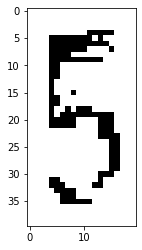

In [95]:
model.evaluate(X_test, y_test[0])

A=plt.imread('Desktop/a4.png')
A.shape
A = np.array(A)
A = A*255

A = cv2.resize(A[:, :, 0], dsize=(20, 40), interpolation=cv2.INTER_CUBIC)
A = reduceNoise(A)
plt.imshow(A, cmap='gray')

print(predict(A))

In [11]:
def density(A, a, b):
    
    dens = 0
    tmp = 0
    
    for i in range(b):
        tmp = 0
        
        j = 0;
        while (j < 40):
            if (A[j, a] == 255):
                dens += tmp
                tmp = 0
                j += 1
                continue
            while (j < 40 and A[j, a+i] != 255):
                j+= 1
                tmp += 1
            j+=1
               
    return dens


def density2(A, a):
    dens = 0
    tmp = 0
       
    j = 0;
    while (j < 40):
        if (A[j, a] == 255):
            dens += tmp*tmp*tmp
            tmp = 0
            j += 1
            continue
        while (j < 40 and A[j, a] != 255):
            j+= 1
            tmp += 1
        j+=1
            
    return dens


def empty(A, a):
    
    cnt = 0

    for i in range(40):
        for j in range(5):
            if (A[i, a+j] == 255):
                cnt+=1
            
    return cnt*cnt

LEN 5


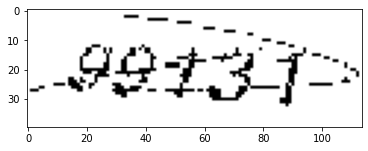

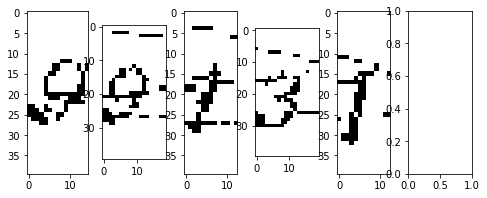

In [101]:
def splitDigit(filepath):
    "Splits the image into digits and puts in a list and return it"
    
    A=plt.imread(filepath)
    A.shape
    A = np.array(A)
    A = A*255
    A = cv2.resize(A[:, :, 0], dsize=((40*A.shape[1])//A.shape[0], 40), interpolation=cv2.INTER_CUBIC)
    A = reduceNoise(A, 3)
    plt.imshow(A, cmap='gray')
    
    l = []
    
    flag = False
    left, right = 0, 0

    i = 0
    while i < A.shape[1]-5:
        
        M = density2(A, i)*density(A, i, 5);
        #print ("D d M i", density2(A, i), density(A, i, 5), "   ", M, i)
        i+=1
        
        if flag == False:
            
            if M > 50:
                left = i-1;
                flag = True;
                i += 10;
                continue
            
        if flag == True:

            if (i-left > 19):
                right = i;
                flag = False;
                l.append(A[:, left-1:right])
                
            elif (M < 50):
                """or (i-left > 18)"""
                right = i
                flag = False;
                l.append(A[:, left-1:right])
                
                
            elif empty(A, i) > 28900:
                while i < A.shape[1]-5 and empty(A, i) > 28900 and i-left < 20:
                    i+=1
                right = i
                flag = False;
                l.append(A[:, left:right])
                
        i+=1
            
    return l

l = splitDigit('Desktop/cap1.png')
print("LEN", len(l))
f , sub = plt.subplots(1,6)
f.set_size_inches(8, 3)
for i in range(len(l)):
    sub[i].imshow(l[i], cmap='gray')

LEN 5


'99131'

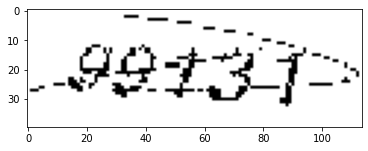

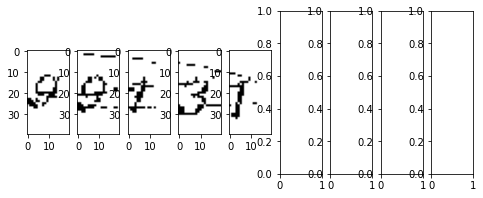

In [110]:
def predictCap(filepath):
    
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    img = reduceNoise(img)
    l = splitDigit(filepath);
    ans = ''
    L = []
    
    for A in l:
        B = np.zeros((40, 20))
        
        for i in range(40):
            for j in range(20):
                B[i][j] = 255;
        
        for i in range(min(40, A.shape[0])):
            for j in range(min (20, A.shape[1])):
                #print(i, j)
                B[i][j] = A[i][j];

        
        ans = ans + predict(B)
        L.append(B)
    
    print("LEN", len(l))
    f , sub = plt.subplots(1,9)
    f.set_size_inches(8, 3)
    for i in range(len(L)):
        sub[i].imshow(L[i], cmap='gray')
        
    for i in range(len(L)):
        plt.imsave(('Desktop/digit' + str(i+1) +'.png'), L[i], cmap = 'gray' )
    
    return ans

predictCap('Desktop/cap1.png')

In [ ]:
import captcha
from captcha.image import ImageCaptcha

ImageCaptcha(fonts = ['Desktop/b.ttf']).write('2', 'Desktop/out.png')

In [ ]:
from claptcha import Claptcha
c = Claptcha("1", "Desktop/font2.ttf", noise=0)

text, img = c.image
img = np.array(img)

img = img[10:130,10:150,:]
res = cv2.resize(img, dsize=(20, 40), interpolation=cv2.INTER_CUBIC)

plt.imshow(res)
#print(res[:,:,0])
print(res.shape)
plt.imshow(res[:,:,0], cmap='gray')
#print("ASASDASDASD")
"""
for i in range(res.shape[0]):
    for j in range (res.shape[1]):
        if res[i][j][0] > 120:
            res[i][j][0] = 255
        if res[i][j][0] != 255:
            res[i][j][0] = 0
#print(res[:,:,0])
cnt = 0;
for i in range(res.shape[0]):
    for j in range (res.shape[1]):
        if res[i][j][0] == 0:
            cnt += 1
"""
print(cnt) # must be more than 49
plt.imshow(res[:,:,0], cmap='gray')

#print(res)

In [1]:
#Creating Dataset for Digits

from random import random
from claptcha import Claptcha
import os.path

sfed = [50, 50, 70, 50, 60, 50, 50, 50, 60, 70] #Samples for each digit
sfed = [10, 10, 20, 10, 15, 10, 10, 10, 15, 20]
sfed = [70, 80, 80, 70, 70, 70, 70, 70, 70, 80]
sfed = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
#sfed = [10, 10, 20, 10, 15, 10, 10, 10, 15, 20]
for fontNum in range(1, 33):
    print("font num:", fontNum)
    
    
    if (i == 1 or ((i>=4) and (i<=7)) or i == 16):
        continue
    
    num = 0
    for char in range(10):

        num = 0

        while (num < sfed[char]):
            
            if os.path.exists('Desktop/fonts/font' + str(fontNum) +'.ttf'):
                c = Claptcha(str(char), "Desktop/fonts/font" + str(fontNum) + ".ttf", noise=0.3)
            else:
                c = Claptcha(str(char), "Desktop/fonts/font" + str(fontNum) + ".otf", noise=0.3)

            text, img = c.image
            img = np.array(img)

            img = img[10:130,10:150,:]
            res = cv2.resize(img, dsize=(20, 40), interpolation=cv2.INTER_CUBIC)

            plt.imshow(res)

            cnt = 0
            for i in range(res.shape[0]):
                for j in range (res.shape[1]):
                    if res[i][j][0] > 120:
                        res[i][j][0] = 255
                    if res[i][j][0] != 255:
                        res[i][j][0] = 0
                        t = random();
                        t*=100;
                        t = t//1
                        if (t%4 == 0):
                            res[i][j] == 255;
                        cnt += 1

            if (cnt < 50):
                num+=1
                continue;

            num += 1;

            plt.imshow(res[:,:,0], cmap='gray')
            cv2.imwrite(('Desktop/digitSamples4/'+'4'+str(10+fontNum)+str(100+num)+str(char)+'.png'), res[:,:,0])

ModuleNotFoundError: No module named 'claptcha'